```!pip install keras_preprocessing```

In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
from os import listdir
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.utils import plot_model
from keras.models import Sequential,load_model
from keras.layers import Dense,Flatten,Embedding,Conv1D,MaxPooling1D
import nltk
import string
import re

In [5]:
def load_doc(filename):
    #open the file  as read only
    file = open(filename,'r')
    # read all text
    text = file.read()
    #close the file
    file.close()
    return text

In [6]:
text = load_doc('/home/dai/Desktop/CDAC/NLP/review_polarity/txt_sentoken/neg/cv000_29416.txt')
text

'plot : two teen couples go to a church party , drink and then drive . \nthey get into an accident . \none of the guys dies , but his girlfriend continues to see him in her life , and has nightmares . \nwhat\'s the deal ? \nwatch the movie and " sorta " find out . . . \ncritique : a mind-fuck movie for the teen generation that touches on a very cool idea , but presents it in a very bad package . \nwhich is what makes this review an even harder one to write , since i generally applaud films which attempt to break the mold , mess with your head and such ( lost highway & memento ) , but there are good and bad ways of making all types of films , and these folks just didn\'t snag this one correctly . \nthey seem to have taken this pretty neat concept , but executed it terribly . \nso what are the problems with the movie ? \nwell , its main problem is that it\'s simply too jumbled . \nit starts off " normal " but then downshifts into this " fantasy " world in which you , as an audience membe

In [7]:
#turn a doc into clean tokens
def clean_doc(doc):
    #split into token by white space
    tokens = doc.split()
    #prepare regex for char filtering
    re_punc = re.compile('[%s]'% re.escape(string.punctuation))
    #remove punctuation from each word
    tokens = [re_punc.sub('',w) for w in tokens]
    #remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    #filter out stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    #filter out short tokens     
    tokens = [word for word in tokens if len(word)>1]
    return tokens

In [8]:
abc = clean_doc(text)
print(len(abc))

330


In [9]:
def dec_to_line(filename,vocab):
    #load the doc
    doc = load_doc(filename)
    #clean doc
    tokens = clean_doc(doc)
    tokens = [w for w in tokens if w in vocab]
    return ' '.join(tokens)

In [10]:
vocab = open("vocab.txt")
vocab = vocab.read().split()

In [11]:
dec_to_line("review_polarity/txt_sentoken/neg/cv000_29416.txt",vocab)

'plot two teen couples go church party drink drive get accident one guys dies girlfriend continues see life nightmares whats deal watch movie sorta find critique mindfuck movie teen generation touches cool idea presents bad package makes review even harder one write since generally applaud films attempt break mold mess head lost highway memento good bad ways making types films folks didnt snag one correctly seem taken pretty neat concept executed terribly problems movie well main problem simply jumbled starts normal downshifts fantasy world audience member idea whats going dreams characters coming back dead others look like dead strange apparitions disappearances chase scenes tons weird things happen simply explained personally dont mind trying unravel film every give clue get kind fed films biggest problem obviously got big secret hide seems want hide completely final five minutes make things entertaining thrilling even engaging meantime really sad part arrow dig flicks like actually 

In [12]:
def process_train(directory,vocab):
    documents = list()
    for filename in listdir(directory):
        if not filename.startswith('cv9'):
            #create a full path of the file to open
            path = directory + '/'+filename
            #load the doc
            doc = load_doc(path)
            #clean the data
            tokens = clean_doc(doc)
            #load the data
            documents.append(tokens)
    return documents

In [13]:
def process_test(directory,vocab):
    documents = list()
    for filename in listdir(directory):
        if filename.startswith('cv9'):
            #create a full path of the file to open
            path = directory + '/'+filename
            #load the doc
            doc = load_doc(path)
            #clean the data
            tokens = clean_doc(doc)
            #load the data
            documents.append(tokens)
    return documents

In [16]:
def process_docs(directory,vocab,is_train):
    documents = list()
    #walks through all the files in the folder
    for filename in listdir(directory):
        #skip any reviews in test set
        if is_train and filename.startswith('cv9'):
            continue
        if not is_train and not filename.startswith('cv9'):
            continue
        #create a full path of the file to open
        path = directory + '/'+filename
        #load the doc
        doc = load_doc(path)
        #clean the data
        tokens = clean_doc(doc)
        #load the data
        documents.append(tokens)
    return documents

In [17]:
lines = process_docs("review_polarity/txt_sentoken/pos/",vocab,False)

In [18]:
len(lines)

100

In [19]:
def load_clean_dataset(vocab,is_train):
    #load documents
    neg = process_docs("review_polarity/txt_sentoken/neg/",vocab,is_train)
    pos = process_docs("review_polarity/txt_sentoken/pos/",vocab,is_train)
    
    docs = neg+pos
    
    #prepare label
    
    labels = [0 for _ in range(len(neg))]+[1 for _ in range(len(pos))]
    return docs,labels

In [22]:
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [23]:
# Integer encode and pad document
def encode_docs(tokenizer,max_length,docs):
    #Integer encode
    encoded = tokenizer.texts_to_sequences(docs)
    #pad sequences
    padded = pad_sequences(encoded,maxlen=max_length,padding='post')
    return padded

In [24]:
#loading data into train and test True = Train,False = Test
train,train_labels = load_clean_dataset(vocab,True)
test,test_labels = load_clean_dataset(vocab,False)

In [25]:
len(train),len(train_labels),len(test),len(test_labels)

(1810, 1810, 200, 200)

In [26]:
#create the tokenizer
tokenizer = create_tokenizer(train)

### **Build A Model**

In [17]:
from keras.models import Sequential
from keras.layers import Dense

In [27]:
def define_model(vocab_size,max_length):
    model = Sequential()
    model.add(Embedding(vocab_size,100,input_length=max_length))
    model.add(Conv1D(filters=32,kernel_size=8,activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(10,activation = 'relu'))
    model.add(Dense(1,activation = 'sigmoid'))

    #compile network
    model.compile(loss = 'binary_crossentropy',optimizer = 'adam',metrics= ['accuracy'])
    #summarize the model
    model.summary()
    plot_model(model,to_file='CNN_model_sentiment.png',show_shapes=True)
    return model
    

In [28]:
define_model(100)

TypeError: define_model() missing 1 required positional argument: 'max_length'

In [22]:
X_train = tokenizer.texts_to_matrix(train,mode = 'binary')

In [23]:
X_train.shape

(1810, 44277)

In [24]:
X_test = tokenizer.texts_to_matrix(test,mode = 'binary')

In [25]:
X_test.shape

(200, 44277)

In [26]:
# to get number of the Times word occurs
tokenizer.word_docs

defaultdict(int,
            {'previously': 59,
             'convincing': 106,
             'drawn': 62,
             'seemed': 160,
             'radiate': 4,
             'nostalgia': 23,
             'zak': 2,
             'warmth': 17,
             'selma': 3,
             'ahh': 3,
             'intentions': 34,
             'son': 201,
             'game': 180,
             'taking': 183,
             'chef': 14,
             'others': 237,
             'aspiring': 17,
             'boymeetsgirl': 4,
             'handling': 23,
             'stopping': 11,
             'ordeal': 10,
             'sticks': 29,
             'frequently': 60,
             'blair': 39,
             'movie': 1380,
             'breakout': 6,
             'goofyembarrassing': 1,
             'hate': 93,
             'impatiently': 2,
             'circumstances': 45,
             'reel': 23,
             'mildly': 35,
             'uninspired': 30,
             'shawn': 9,
             'cook': 19,
  

In [27]:
n_words = X_train.shape[1]
model = define_model(n_words)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 50)                2213900   
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 2213951 (8.45 MB)
Trainable params: 2213951 (8.45 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [28]:
model.fit(X_train,np.array(train_labels),epochs = 10,batch_size = 5)

Epoch 1/10
362/362 [==============================] - 8s 18ms/step - loss: 0.4202 - accuracy: 0.8083
Epoch 2/10
362/362 [==============================] - 6s 18ms/step - loss: 0.0256 - accuracy: 0.9950
Epoch 3/10
362/362 [==============================] - 6s 18ms/step - loss: 0.0035 - accuracy: 1.0000
Epoch 4/10
362/362 [==============================] - 6s 17ms/step - loss: 7.2605e-04 - accuracy: 1.0000
Epoch 5/10
362/362 [==============================] - 7s 18ms/step - loss: 2.5604e-04 - accuracy: 1.0000
Epoch 6/10
362/362 [==============================] - 6s 18ms/step - loss: 1.4209e-04 - accuracy: 1.0000
Epoch 7/10
362/362 [==============================] - 6s 17ms/step - loss: 8.7689e-05 - accuracy: 1.0000
Epoch 8/10
362/362 [==============================] - 6s 17ms/step - loss: 5.9963e-05 - accuracy: 1.0000
Epoch 9/10
362/362 [==============================] - 6s 18ms/step - loss: 4.2763e-05 - accuracy: 1.0000
Epoch 10/10
362/362 [==============================] - 6s 18ms/step

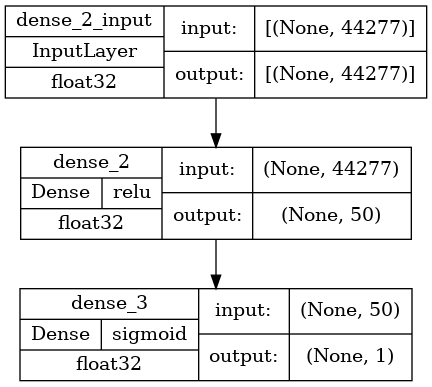

In [31]:
plot_model(model,show_dtype = True,show_layer_activations = True,show_shapes = True,show_layer_names = True)

In [33]:
model.evaluate(X_test,np.array(test_labels),batch_size = 1)

200/200 [==============================] - 1s 4ms/step - loss: 0.2449 - accuracy: 0.9250


[0.24493873119354248, 0.925000011920929]

In [34]:
text1 = 'Best Movie ever !  It was great, i will definitely recommended it.'
text2 = 'this is bad movie'

In [65]:
def predict_data(text,vocab):
    
    tokens = clean_doc(text)
    tokens = [w for w in tokens if w in vocab]
    tokens = ' '.join(tokens)
    x_new = tokenizer.texts_to_matrix([tokens],mode = 'binary')
    y_pred = model.predict(x_new,verbose=0)
    if round(y_pred[0][0])==1:
        print("Positive Review: ", y_pred[0][0])
    elif(round(y_pred[0][0])==0):
        print("Negative Review: ", y_pred[0][0])
    

In [66]:
predict_data(text1,vocab)

Positive Review:  0.7038161


In [67]:
predict_data(text2,vocab)

Negative Review:  0.35022599
